+ 앙상블 모형(emsemble) : 여러개의 분류모형에 의한 결과를 종합하여 분류의 정확도를 높이는 방법
  + 새로운 자료에 대해 분류기 예측값들의 가중투표를 통해 분류를 수행
  + 장점
    1) 평균을 취함으로써 편의를 제거함
    2) 분산을 감소시킴
    3) 과적합의 가능성을 줄여줌

+ 배깅 : 원 데이터 셋으로부터 크기가 같은 표본을 여러 번 단순임의복원추출하여 각 표본(붓스트랩 표본)에 대해 분류기를 생성한 후 그 결과를 앙상블하는 방법
  + 반복 추출방법을 사용하기에 같은 데이터가 한 표본에 여러번 추출될 수도 있고, 어떤 데이터는 추출되지 않을 수도 있음
    + 추출되지 않는 자료는 약 36.8%정도인데 이는 test로 사용되어 train, test로 처음부터 나누지 않아도 된다는 특징을 가지게 함
      + 장점 : 알고리즘 상에서 자동분류

## 예제 1. bagging(){adabag}

In [25]:
install.packages("adabag")
library(adabag)
data(iris)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘htmlwidgets’, ‘XML’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘iterators’, ‘rgl’, ‘rlist’, ‘gtools’, ‘caret’, ‘foreach’, ‘doParallel’, ‘ConsRank’


Loading required package: rpart

Loading required package: caret

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:kernlab’:

    alpha


Loading required package: lattice

Loading required package: foreach

Loading required package: doParallel

Loading required package: iterators

Loading required package: parallel

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNU

Petal.Length  Petal.Width Sepal.Length  Sepal.Width 
    74.31474     25.68526      0.00000      0.00000

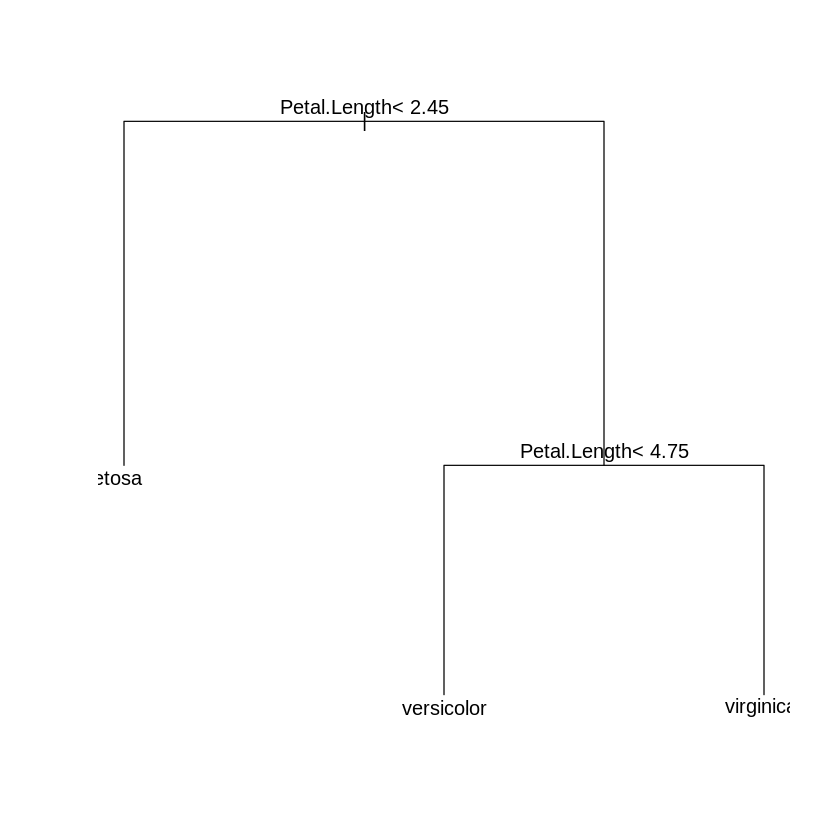

In [26]:
iris.bagging = bagging(Species ~ ., data = iris, mfinal = 10)  # mfinal = 반복수, 트리 수
iris.bagging$importance  # 변수의 상대적인 중요도
plot(iris.bagging$trees[[10]])  # 10번째 모형으로 출력
text(iris.bagging$trees[[10]])

In [27]:
pred = predict(iris.bagging, newdata = iris)  # 예측
table(pred$class, iris[,5])

            
             setosa versicolor virginica
  setosa         50          0         0
  versicolor      0         47         4
  virginica       0          3        46

+ 부스팅 : 분류가 잘못된 데이터에 더 큰 가중을 주어 표본을 추출
  + ex - 아다부스팅

## 예제 2. boosting(){adabag}

Petal.Length  Petal.Width Sepal.Length  Sepal.Width 
   67.452811    20.921752     3.690547     7.934889

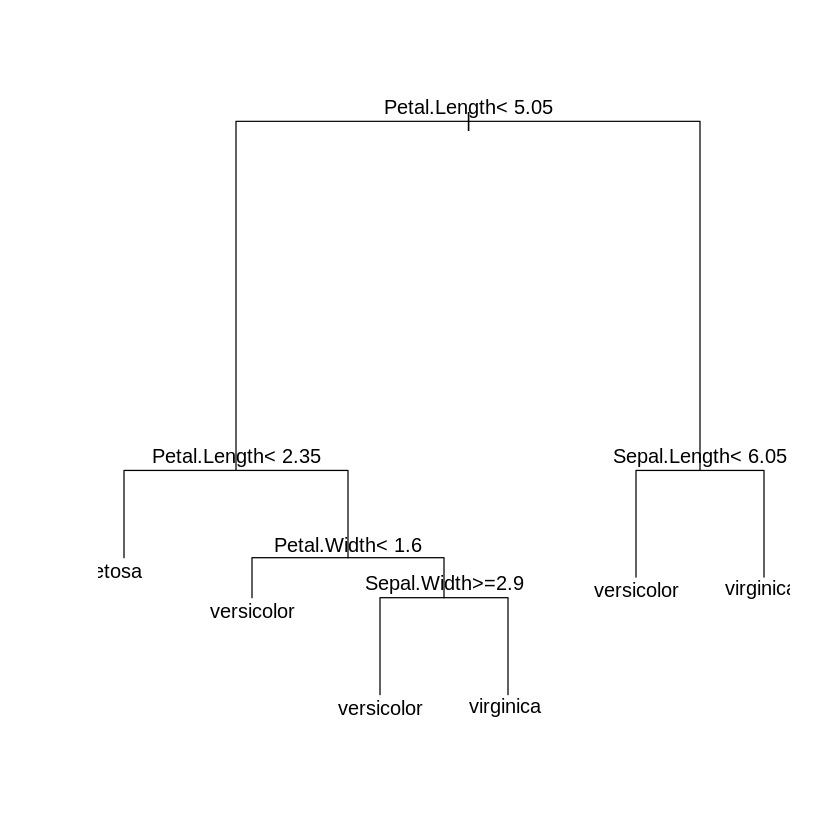

In [28]:
library(adabag)
data(iris)
boo.adabag = boosting(Species ~ ., data = iris, boos = TRUE, mfinal = 10)
boo.adabag$importance  # 예제 1에 비해 중요도가 골고루 분포
plot(boo.adabag$trees[[10]])  # 예제 1에 비해 훨씬 복잡함
text(boo.adabag$trees[[10]])

In [29]:
pred = predict(boo.adabag, newdata = iris)
tb = table(pred$class, iris[, 5])
tb  # 오분류 zero

            
             setosa versicolor virginica
  setosa         50          0         0
  versicolor      0         50         0
  virginica       0          0        50

In [30]:
error.rpart = 1 - (sum(diag(tb)) / sum(tb))
error.rpart

[1] 0

## 예제 3. ada(){ada}

In [31]:
install.packages("ada")
library(ada)
data(iris)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [32]:
iris[iris$Species != "setosa", ] -> iris  # setosa 50개 자료 제외
n = dim(iris)[1]
trind = sample(1:n, floor(.6*n), FALSE)
teind = setdiff(1:n, trind)
# [as.numeric(iris[, 5])-1] : 0, 1, 2가 차례로 50개(총 150개)
iris[,5] = as.factor((levels(iris[,5])[2:3])[as.numeric(iris[, 5])-1])
gdis = ada(Species ~ ., data = iris[trind, ], iter = 20, nu = 1, type = "discrete")
# nu = 부스팅 축소 모수로 디폴트는 1
# type = 부스팅 알고리즘 지정, 디폴트는 discrete
gdis = addtest(gdis, iris[teind, -5], iris[teind, 5])
gdis  # OOB : 포함되지 않은 자료에 대한 test 결과

Call:
ada(Species ~ ., data = iris[trind, ], iter = 20, nu = 1, type = "discrete")

Loss: exponential Method: discrete   Iteration: 20 

Final Confusion Matrix for Data:
            Final Prediction
True value   versicolor virginica
  versicolor         27         0
  virginica           0        33

Train Error: 0 

Out-Of-Bag Error:  0  iteration= 18 

Additional Estimates of number of iterations:

train.err1 train.kap1 test.errs2 test.kaps2 
         8          8          4          4 


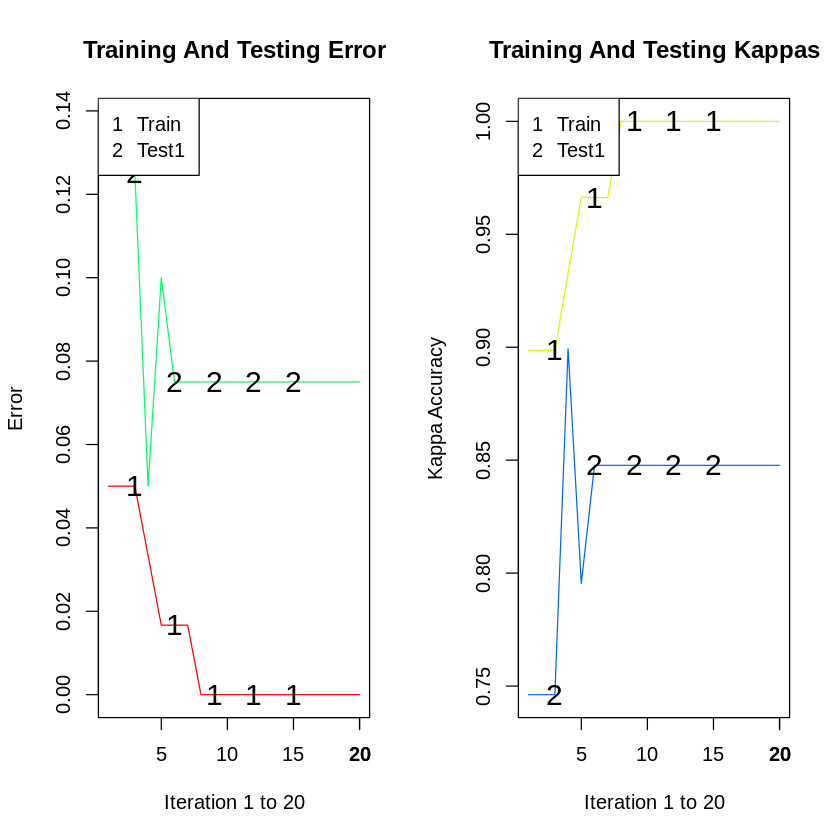

In [33]:
plot(gdis, TRUE, TRUE)  # kappa 계수 + 훈련용, 검증용 자료 둘 다 ploting

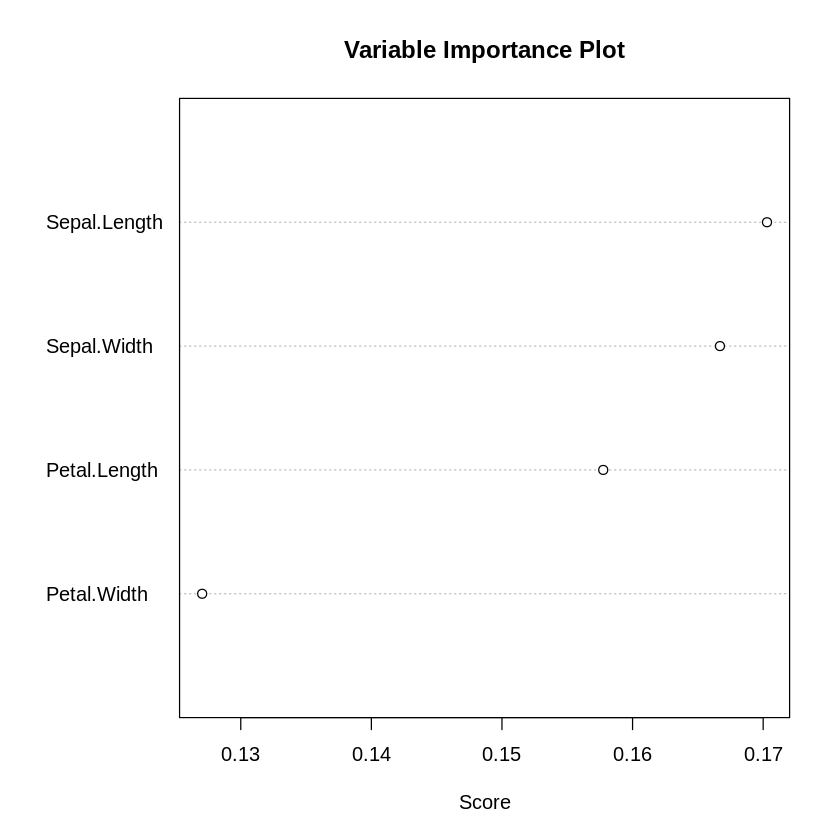

In [34]:
varplot(gdis)  # 변수의 중요도
# maxvar = 변수의 수 지정

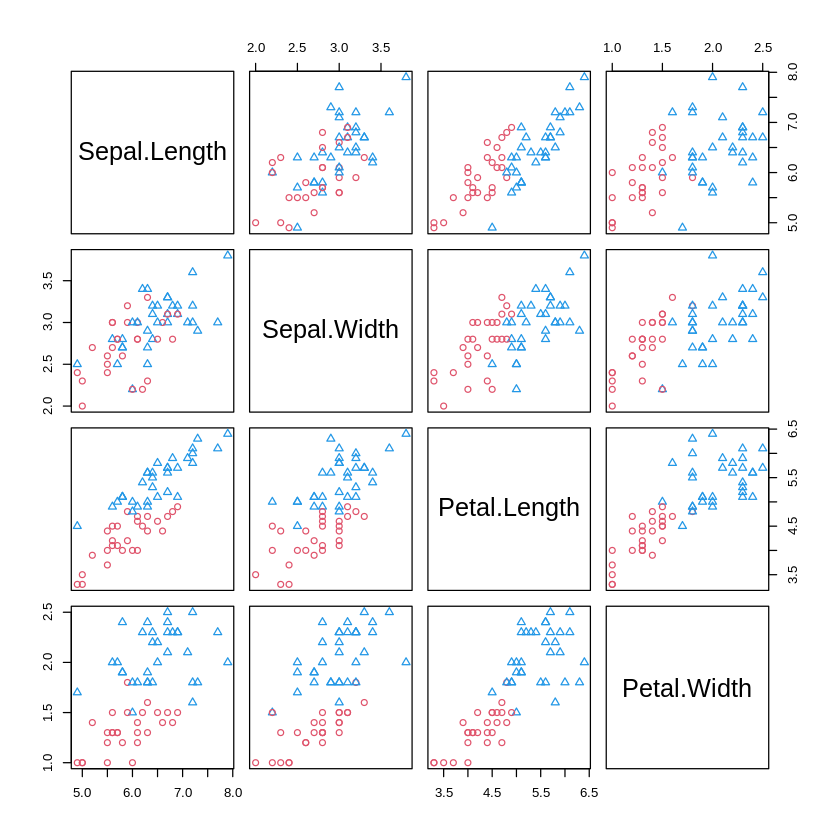

In [35]:
pairs(gdis, iris[trind, -5], maxvar = 4)  # 두 예측변수의 조합별로 분류된 결과를 보여줌

+ random forest : bagging + 변수 임의선택
  + 데이터 전체 중 최적을 찾는 것(bagging)이 아니라 몇 개를 임의로 선택해서 그 중 최적을 찾음
  + 예측변수들을 임의로 추출하고, 추출된 변수 내에서 최적의 분할을 만들어가는 방법
    + 분류 : 다수결, 회귀 : 평균
  + 다양한 의견으로 다양한 모형을 만들 수 있음


## 예제 4. randomForest()

In [36]:
install.packages("party")
library(party)
data(stagec)
str(stagec)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TH.data’, ‘libcoin’, ‘matrixStats’, ‘multcomp’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’


Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4


Attaching package: ‘modeltools’


The following object is masked from ‘package:kernlab’:

    prior


Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich



'data.frame':	146 obs. of  8 variables:
 $ pgtime : num  6.1 9.4 5.2 3.2 1.9 4.8 5.8 7.3 3.7 15.9 ...
 $ pgstat : int  0 0 1 1 1 0 0 0 1 0 ...
 $ age    : int  64 62 59 62 64 69 75 71 73 64 ...
 $ eet    : int  2 1 2 2 2 1 2 2 2 2 ...
 $ g2     : num  10.26 NA 9.99 3.57 22.56 ...
 $ grade  : int  2 3 3 2 4 3 2 3 3 3 ...
 $ gleason: int  4 8 7 4 8 7 NA 7 6 7 ...
 $ ploidy : Factor w/ 3 levels "diploid","tetraploid",..: 1 3 1 1 2 1 2 3 1 2 ...


In [37]:
stagec1 = subset(stagec, !is.na(g2))
stagec2 = subset(stagec1, !is.na(gleason))
stagec3 = subset(stagec2, !is.na(eet))
str(stagec3)

'data.frame':	134 obs. of  8 variables:
 $ pgtime : num  6.1 5.2 3.2 1.9 4.8 3.7 15.9 6.3 2.9 1.5 ...
 $ pgstat : int  0 1 1 1 0 1 0 0 1 1 ...
 $ age    : int  64 59 62 64 69 73 64 65 58 70 ...
 $ eet    : int  2 2 2 2 1 2 2 2 2 2 ...
 $ g2     : num  10.26 9.99 3.57 22.56 6.14 ...
 $ grade  : int  2 3 2 4 3 3 3 3 4 3 ...
 $ gleason: int  4 7 4 8 7 6 7 7 8 8 ...
 $ ploidy : Factor w/ 3 levels "diploid","tetraploid",..: 1 1 1 2 1 1 2 2 2 1 ...


In [38]:
set.seed(1234)
ind = sample(2, nrow(stagec3), replace = TRUE, prob = c(0.7, 0.3))
ind

[1] 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 2 1
 [38] 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 2 2 1 1 1 1 2 1 1 1 1 1 2 1 2
 [75] 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2
[112] 1 2 1 1 2 2 1 1 2 2 2 2 2 1 1 1 1 1 1 2 1 1 1

In [39]:
trainData = stagec3[ind == 1,]  # n = 102개
testData = stagec3[ind == 2,]  # n = 32개

In [40]:
install.packages("randomForest")
library(randomForest)
# proximity = 개체들 간의 근접도 행렬 제공 : 동일한 최종노드에 포함되는 빈도에 기초함
rf = randomForest(ploidy ~ ., data = trainData, ntree = 100, proximity = TRUE)
table(predict(rf), trainData$ploidy)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




            
             diploid tetraploid aneuploid
  diploid         45          0         3
  tetraploid       1         51         0
  aneuploid        2          0         0

In [41]:
print(rf)


Call:
 randomForest(formula = ploidy ~ ., data = trainData, ntree = 100,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 2

        OOB estimate of  error rate: 5.88%
Confusion matrix:
           diploid tetraploid aneuploid class.error
diploid         45          1         2      0.0625
tetraploid       0         51         0      0.0000
aneuploid        3          0         0      1.0000


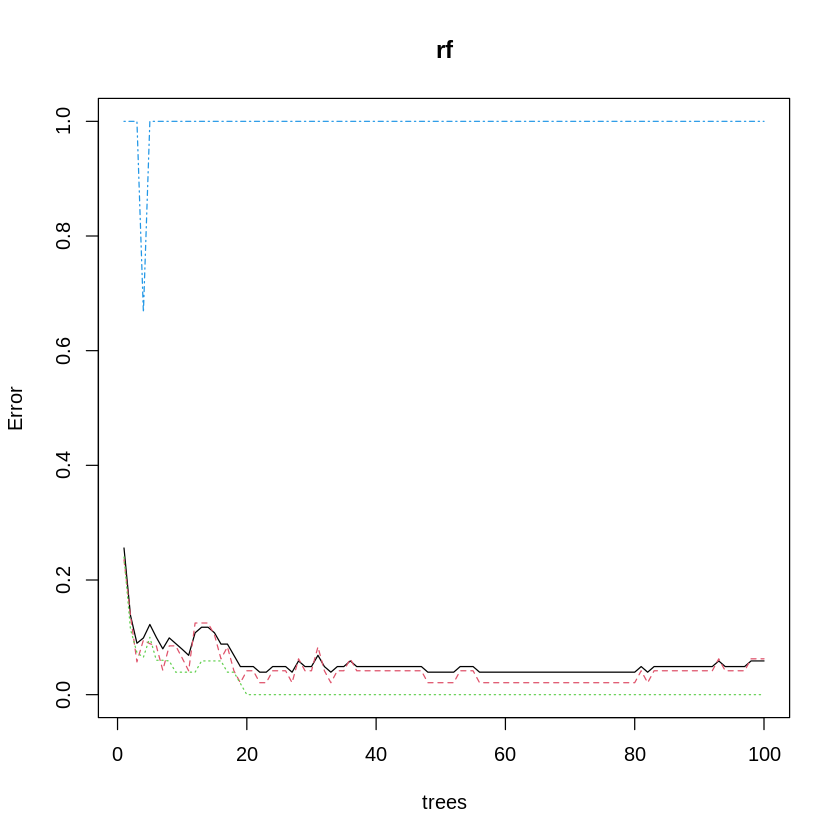

In [42]:
plot(rf)  # 트리 수에 따른 종속변수의 범주별 오분류율

In [43]:
importance(rf)  # 변수의 중요도

,MeanDecreaseGini
pgtime,4.6800225
pgstat,2.0635061
age,3.5726107
eet,0.7875501
g2,37.5032896
grade,1.2084410
gleason,2.0820408


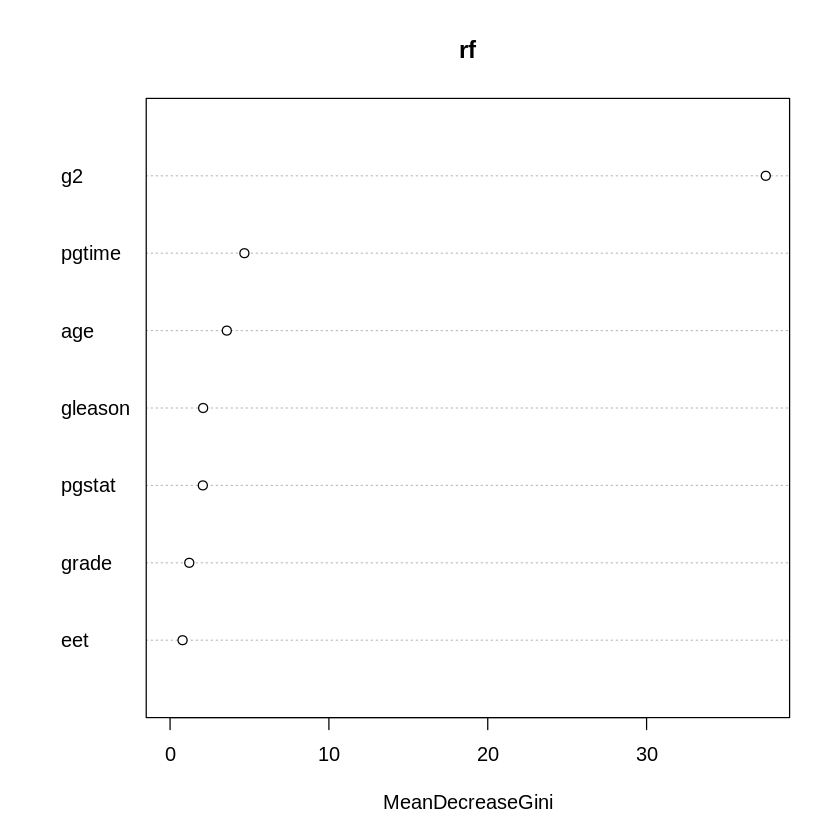

In [44]:
varImpPlot(rf)

+ 랜덤포리스트에서는 별도의 검증용 데이터를 사용하지 않더라도 붓스트랩 샘플과정에서 제외된(out-of-bag) 자료를 사용하여 검증을 실시할 수 있다.
+ 변수의 중요도 : 각 변수로 인한 불순도의 평균 감소량이 클수록 순수도가 증가하여 변수의 중요도가 높음

In [45]:
rf.pred = predict(rf, newdata = testData)
table(rf.pred, testData$ploidy)

            
rf.pred      diploid tetraploid aneuploid
  diploid         17          0         1
  tetraploid       0         13         1
  aneuploid        0          0         0

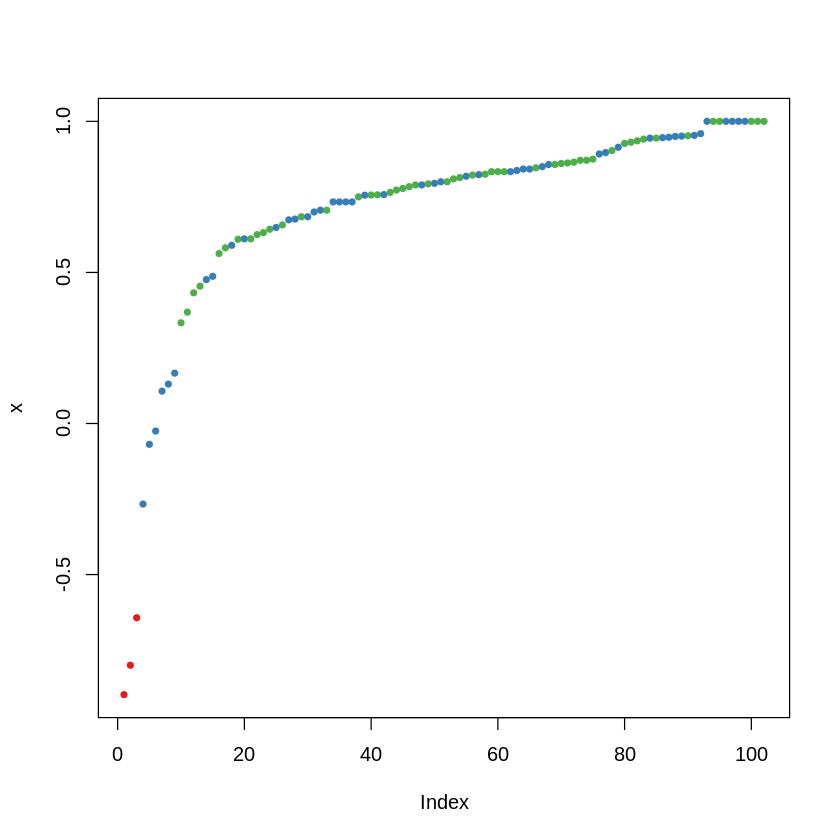

In [46]:
plot(margin(rf))  # 마진

+ 마진 : 정분류를 수행한 비율에서 다른 클래스로 분류한 비율의 최댓값을 뺀 값
  + 양의 마진 : 정확한 분류를 의미, 음은 그 반대

## 추가 예제. cforest(){party}

In [47]:
set.seed(12345)
cf = cforest(ploidy ~ ., data = trainData)
cf.pred = predict(cf, newdata = testData, OOB = TRUE, type = "response")
table(cf.pred, testData$ploidy)

            
cf.pred      diploid tetraploid aneuploid
  diploid         17          0         1
  tetraploid       0         13         1
  aneuploid        0          0         0

# 10.5절 {caret}를 이용한 랜덤포리스트

In [49]:
install.packages("caret")
install.packages("ggplot2")
require(caret)
require(ggplot2)
require(randomForest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [50]:
# 자료 읽기
training_URL = "http://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv"
test_URL = "http://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv"
training = read.csv(training_URL, na.strings = c("NA",""))
test = read.csv(test_URL, na.strings = c("NA",""))

In [51]:
# 불필요한 열 제외
training = training[, 7:160]
test = test[, 7:160]

In [52]:
# 결측치 제거
mostly_data = apply(!is.na(training), 2, sum) > 19621
training = training[, mostly_data]
test = test[, mostly_data]
dim(training)  # 결측이 없는 열의 수 = 54

[1] 19622    54

In [53]:
# train 설정
InTrain = createDataPartition(y = training$classe, p=0.3, list=FALSE)
# list= 결과를 list로 저장할지의 여부
training1 = training[InTrain,]

In [54]:
# {caret}을 이용한 랜덤포레스트 수행
library(caret)
# 5-fold cross validation
# prox = 근접도행렬
rf_model = train(classe ~ ., data = training1, method = "rf", trControl = trainControl(method = "cv", number = 5),
                  prox = TRUE, allowParallel = TRUE)
print(rf_model)  # mtry는 매 분할에서 임의로 선택될 후보 변수의 수
print(rf_model$finalModel)  # 정확도 : 1 - OOB error rate = 99.15%

Random Forest 

5889 samples
  53 predictor
   5 classes: 'A', 'B', 'C', 'D', 'E' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 4711, 4710, 4712, 4711, 4712 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9836987  0.9793746
  27    0.9894696  0.9866794
  53    0.9869218  0.9834536

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 27.

Call:
 randomForest(x = x, y = y, mtry = param$mtry, proximity = TRUE,      allowParallel = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 27

        OOB estimate of  error rate: 0.78%
Confusion matrix:
     A    B    C   D    E class.error
A 1674    0    0   0    0 0.000000000
B    6 1126    8   0    0 0.012280702
C    0    9 1015   3    0 0.011684518
D    0    0    7 958    0 0.007253886
E    0    3    1   9 1070 0.01200